Creando features (lags y tendencias)...

Filas totales antes de limpiar: 7806
Filas después de limpiar NaNs (lags): 7676
Filas finales para análisis (Pre-COVID): 6938

Distribución de Alertas (> 20%):
Y_ALERTA
1    0.567599
0    0.432401
Name: proportion, dtype: float64

--- Ejecutando Modelo Logit ---
Optimization terminated successfully.
         Current function value: 0.652070
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Y_ALERTA   No. Observations:                 6938
Model:                          Logit   Df Residuals:                     6932
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Nov 2025   Pseudo R-squ.:                 0.04665
Time:                        03:55:50   Log-Likelihood:                -4524.1
converged:                       True   LL-Null:                       -4745.5
Covariance Type:            nonrobust   L

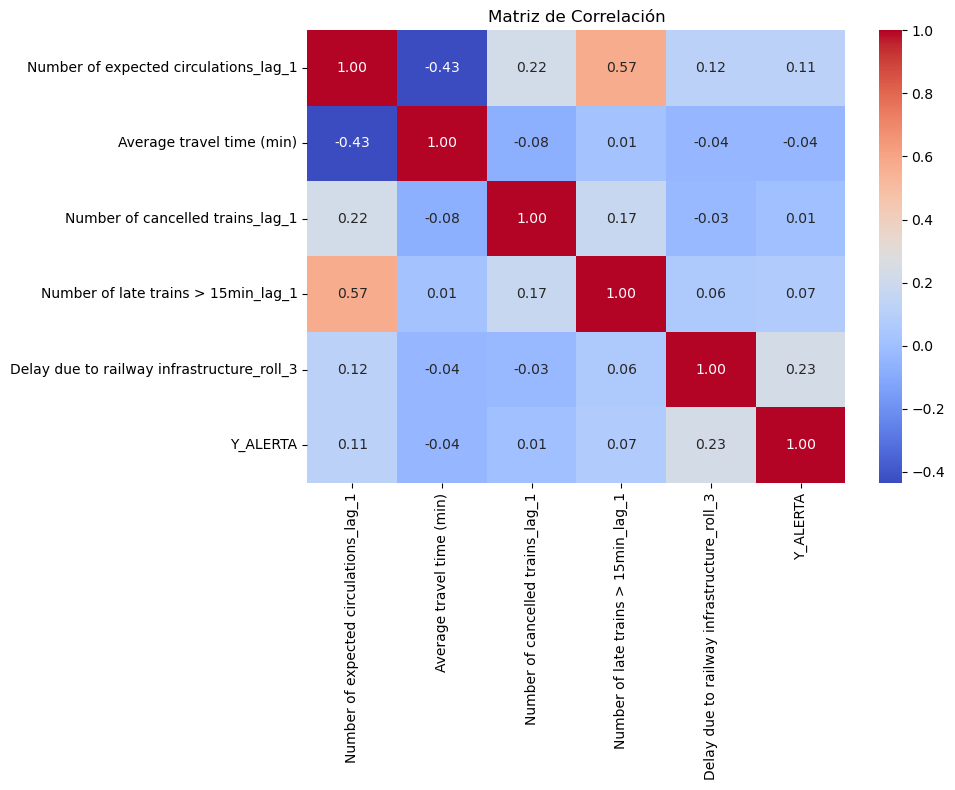

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# --- 1. Cargar y Limpiar Datos ---
file_path = r'C:\Users\danny\OneDrive\Escritorio\ARyC\Mod_Reg\dataset de prueba\Regularities_by_liaisons_Trains_France.csv'
df = pd.read_csv(file_path)

# Crear fecha y ruta
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(int).astype(str))
df['Route'] = df['Departure station'] + ' - ' + df['Arrival station']
df = df.sort_values(by=['Route', 'Date'])

# --- 2. Definir Variables ---
predictor_cols = [
    'Number of expected circulations',
    'Average travel time (min)',
    'Number of cancelled trains',
    'Number of late trains at departure',
    'Number of trains late on arrival',
    'Number of late trains > 15min'
]
target_col = 'Delay due to railway infrastructure'

# Llenar NaNs en las columnas base
cols_to_fill = predictor_cols + [target_col]
df[cols_to_fill] = df[cols_to_fill].fillna(0)

# --- 3. Feature Engineering ---
print("Creando features (lags y tendencias)...")
features_created = []

for col in predictor_cols + [target_col]:
    # Lag 1
    lag_name = f'{col}_lag_1'
    df[lag_name] = df.groupby('Route')[col].shift(1)
    features_created.append(lag_name)
    
    # Promedio móvil 3 meses (solo para la infraestructura)
    if col == target_col:
        roll_name = f'{col}_roll_3'
        df[roll_name] = df.groupby('Route')[col].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
        features_created.append(roll_name)

# Definimos EXACTAMENTE qué columnas usaremos en el modelo final
final_features = [
    'Number of expected circulations_lag_1',
    'Average travel time (min)',
    'Number of cancelled trains_lag_1',
    'Number of late trains > 15min_lag_1',
    'Delay due to railway infrastructure_roll_3'
]

# --- 4. Limpieza de NaNs (CORREGIDA) ---
print(f"\nFilas totales antes de limpiar: {len(df)}")

# Solo eliminamos filas si faltan datos en las columnas que usaremos
cols_to_check = final_features + [target_col, 'Date']
df_model = df.dropna(subset=cols_to_check)

print(f"Filas después de limpiar NaNs (lags): {len(df_model)}")

# Filtramos Pre-COVID
df_analysis = df_model[df_model['Date'] < '2020-01-01'].copy()
print(f"Filas finales para análisis (Pre-COVID): {len(df_analysis)}")

if len(df_analysis) == 0:
    raise ValueError("¡Error! No quedan datos para el análisis. Verifica las fechas o columnas.")

# --- 5. Crear Variable Binaria Y (Alerta) ---
threshold = 20
df_analysis['Y_ALERTA'] = (df_analysis[target_col] > threshold).astype(int)

print(f"\nDistribución de Alertas (> {threshold}%):")
print(df_analysis['Y_ALERTA'].value_counts(normalize=True))

# --- 6. Ejecutar Regresión Logística (Logit) ---
X = df_analysis[final_features]
y = df_analysis['Y_ALERTA']

# Añadir constante para statsmodels
X = sm.add_constant(X)

print("\n--- Ejecutando Modelo Logit ---")
try:
    logit_model = sm.Logit(y, X).fit()
    print(logit_model.summary())
    
    # --- 7. Interpretación (Odds Ratios) ---
    print("\n--- Interpretación: Odds Ratios (Impacto en Probabilidad) ---")
    params = logit_model.params
    conf = logit_model.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
    # Convertir log-odds a odds ratios normales
    odds_ratios = np.exp(conf)
    print(odds_ratios[['Odds Ratio', '2.5%', '97.5%']])
    
except Exception as e:
    print("\nError al ajustar el modelo:", e)

# --- 8. Matriz de Correlación ---
plt.figure(figsize=(10, 8))
corr_matrix = pd.concat([X.drop(columns='const'), y], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

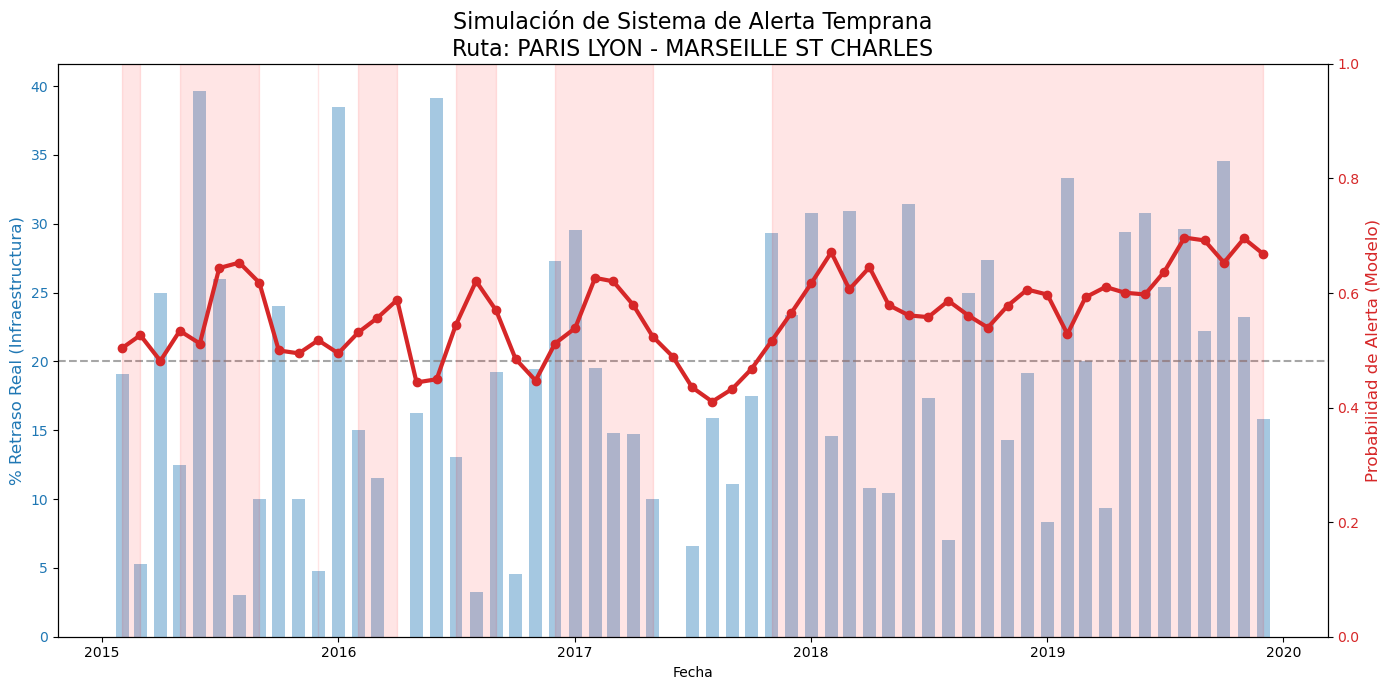

Análisis para PARIS LYON - MARSEILLE ST CHARLES:
Las zonas sombreadas en rojo indican meses donde el modelo hubiera activado una ALERTA (>50% probabilidad).
Observa si las barras azules altas caen dentro o justo después de que la línea roja sube.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# --- 1. Preparación de Datos  ---
file_path = r'C:\Users\danny\OneDrive\Escritorio\ARyC\Mod_Reg\dataset de prueba\Regularities_by_liaisons_Trains_France.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(int).astype(str))
df['Route'] = df['Departure station'] + ' - ' + df['Arrival station']
df = df.sort_values(by=['Route', 'Date'])

predictor_cols = [
    'Number of expected circulations',
    'Average travel time (min)',
    'Number of cancelled trains',
    'Number of late trains > 15min'
]
target_col = 'Delay due to railway infrastructure'

df[predictor_cols + [target_col]] = df[predictor_cols + [target_col]].fillna(0)

# Feature Engineering (Las variables que sabemos que importan)
# Incluimos 'roll_3' que fue la más significativa
for col in predictor_cols:
    df[f'{col}_lag_1'] = df.groupby('Route')[col].shift(1)

df[f'{target_col}_roll_3'] = df.groupby('Route')[target_col].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)

# Limpiar y Filtrar
features_model = [
    'Number of expected circulations_lag_1', 
    'Delay due to railway infrastructure_roll_3' # La variable estrella
]

df_model = df.dropna(subset=features_model + [target_col])
df_analysis = df_model[df_model['Date'] < '2020-01-01'].copy()

# Definir Alerta (Umbral > 20%)
threshold = 20
df_analysis['Y_ALERTA'] = (df_analysis[target_col] > threshold).astype(int)

# --- 2. Entrenar el Modelo ---
X = df_analysis[features_model]
X = sm.add_constant(X)
y = df_analysis['Y_ALERTA']

logit_model = sm.Logit(y, X).fit(disp=0)

# --- 3. Simulación en una Ruta Específica ---
route_name = 'PARIS LYON - MARSEILLE ST CHARLES'
# route_name = 'PARIS MONTPARNASSE - BORDEAUX ST JEAN' # Otra opción

# Extraer datos solo de esa ruta
route_data = df_analysis[df_analysis['Route'] == route_name].copy()

if len(route_data) == 0:
    print(f"No hay datos para la ruta {route_name}")
else:
    # Predecir la probabilidad de alerta para esta ruta mes a mes
    X_route = sm.add_constant(route_data[features_model])
    # Asegurar que la constante esté presente (a veces sm se queja si es una sola fila, pero aquí son muchas)
    X_route['const'] = 1.0 
    
    # Obtener probabilidad (0 a 1)
    route_data['Probabilidad_Alerta'] = logit_model.predict(X_route)

    # --- 4. Visualización de Alto Impacto ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Eje Izquierdo (Barras): El Retraso REAL
    color_bar = 'tab:blue'
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('% Retraso Real (Infraestructura)', color=color_bar, fontsize=12)
    bars = ax1.bar(route_data['Date'], route_data[target_col], color=color_bar, alpha=0.4, label='Retraso Real', width=20)
    ax1.tick_params(axis='y', labelcolor=color_bar)
    
    # Línea de Umbral de Desastre (20%)
    ax1.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7, label=f'Umbral de Alerta ({threshold}%)')

    # Eje Derecho (Línea): La Probabilidad del Modelo
    ax2 = ax1.twinx()  
    color_line = 'tab:red'
    ax2.set_ylabel('Probabilidad de Alerta (Modelo)', color=color_line, fontsize=12)
    line = ax2.plot(route_data['Date'], route_data['Probabilidad_Alerta'], color=color_line, linewidth=3, marker='o', label='Riesgo Calculado')
    ax2.tick_params(axis='y', labelcolor=color_line)
    ax2.set_ylim(0, 1) # Probabilidad siempre es 0-1

    # Rellenar zona de peligro
    # Si la probabilidad supera el 50%, sombreamos en rojo
    ax2.fill_between(route_data['Date'], 0, 1, 
                     where=(route_data['Probabilidad_Alerta'] > 0.5), 
                     color='red', alpha=0.1, transform=ax2.get_xaxis_transform())

    plt.title(f'Simulación de Sistema de Alerta Temprana\nRuta: {route_name}', fontsize=16)
    fig.tight_layout()
    plt.show()

    print(f"Análisis para {route_name}:")
    print("Las zonas sombreadas en rojo indican meses donde el modelo hubiera activado una ALERTA (>50% probabilidad).")
    print("Observa si las barras azules altas caen dentro o justo después de que la línea roja sube.")